# SMILE: Cost-sensitive Multi-task Learning for Nuclear Segmentation and Classification with Imbalanced Annotations


For processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />

- Output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- Output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus

In this notebook, we demonstrate how to utilise the output generated by different settings.

In [20]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json

from misc.viz_utils import visualize_instances_dict

In [21]:
# first, we shall set the image tile, WSI and output paths.

tile_path = 'dataset/sample_images/imgs/'
tile_json_path = 'dataset/sample_images/pred/json/'
tile_mat_path = 'dataset/sample_images/pred/mat/'
tile_overlay_path = 'dataset/sample_images/pred/overlay/'


## Tile Processing Output

First let's view the 2D output from tile processing mode, that is stored in a `.mat` file.

In [22]:
# load the original image, the `.mat` file and the overlay

image_list = glob.glob(tile_path + '*.png')
image_list.sort()

# get a random image 
rand_nr = np.random.randint(0,len(image_list))
image_file = image_list[rand_nr]

basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get the corresponding `.mat` file 
result_mat = sio.loadmat(tile_mat_path + basename + '.mat')

# get the overlay
overlay = cv2.imread(tile_overlay_path + basename + '.png')
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

In [23]:
# ** now, let's get the outputs and print some basic shape information
# 2D map where each nucleus has a unique ID assigned. 0 is background
inst_map = result_mat['inst_map'] 
# Nx2 length array denoting nuclear type predictions. N is the number of nuclei
# idx=0 denotes the corresponding inst_id in the `inst_map` and 
# idx=1 denotes the type of that inst_id
inst_type = result_mat['inst_type'] 

print('instance map shape', inst_map.shape)

instance map shape (833, 748)


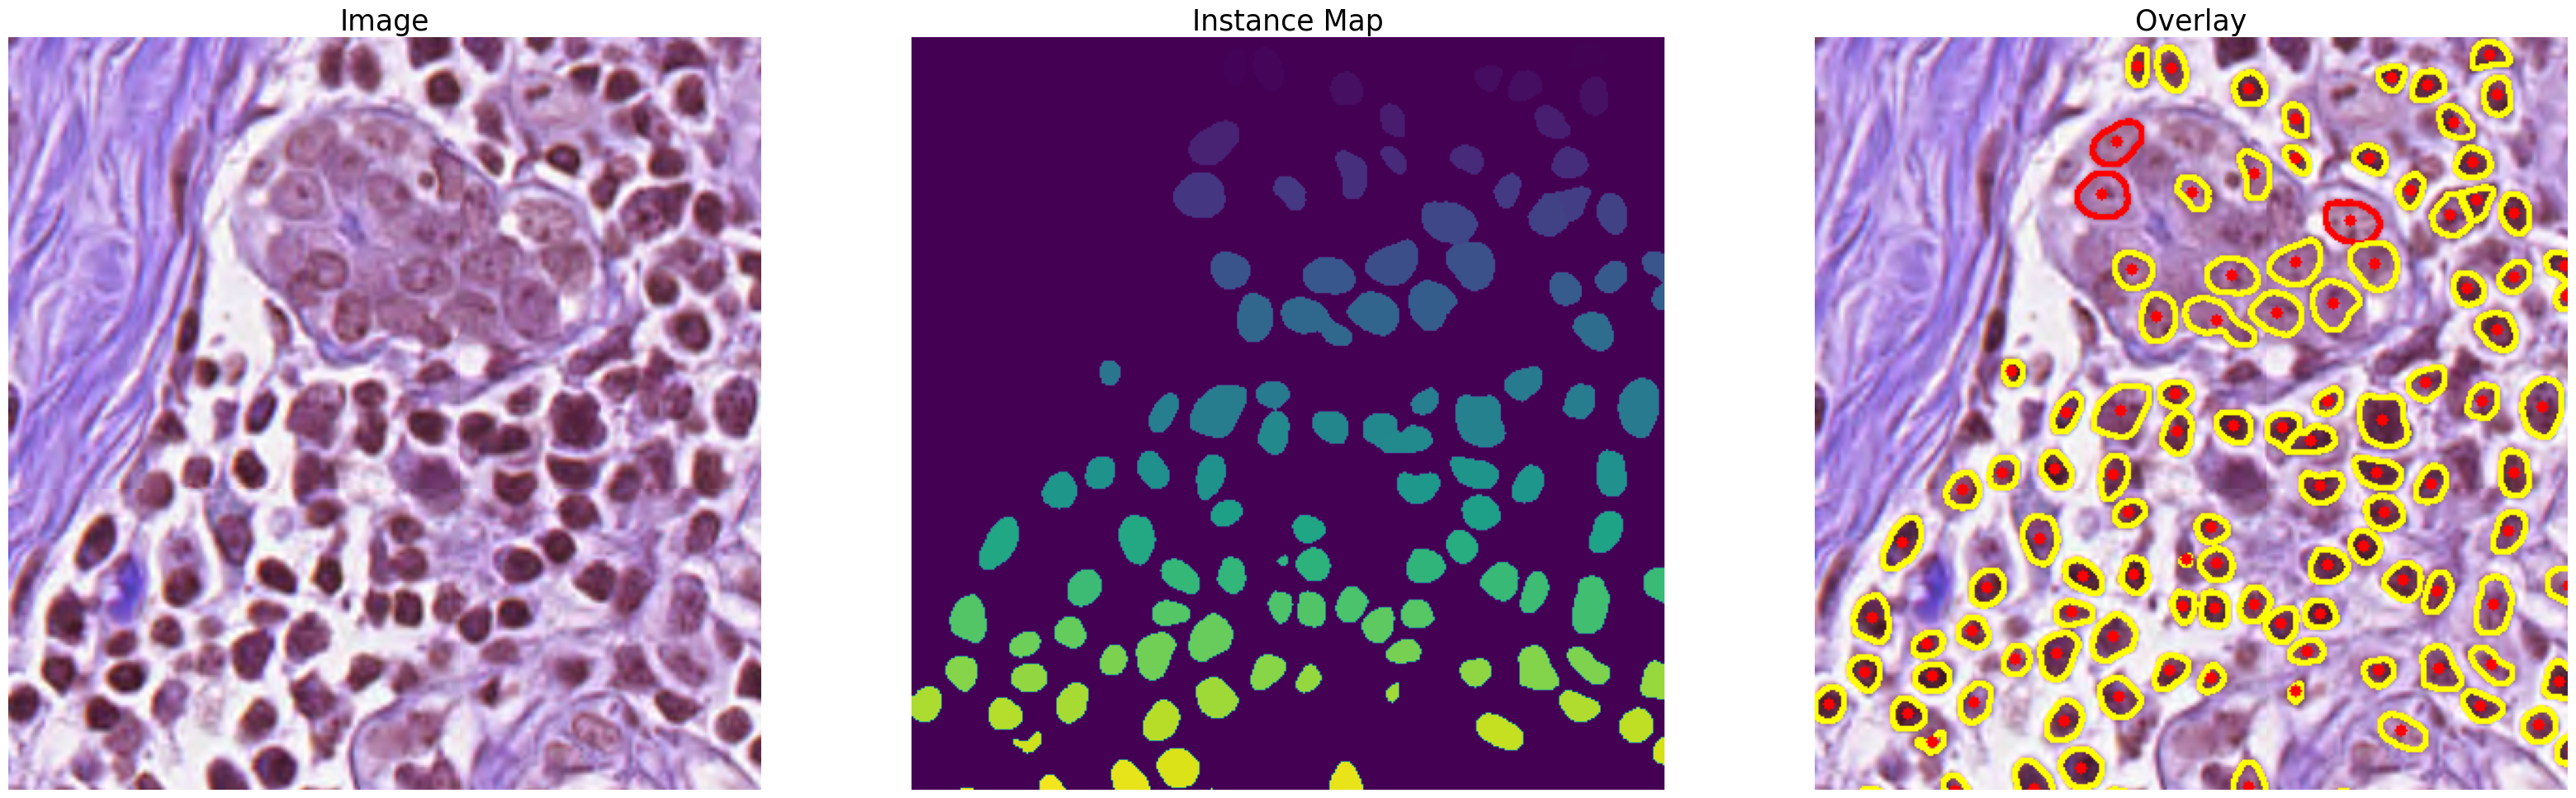

In [24]:
# plot the original image, along with the instance map and the overlay

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image[:400,:400,:])
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(inst_map[:400,:400])
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(overlay[:400,:400,:])
plt.axis('off')
plt
plt.title('Overlay', fontsize=25)

plt.show()

We observe that the values range from 0 (background) to N where N is the number of classes. See below what these values refer to for different datasets.

## CoNSeP

1) Epithelial <br />
2) Inflammatory <br />
3) Spindle-Shaped <br />
4) Miscellaneous

## MoNuSAC

1) Epithelial <br />
2) Lymphocyte <br />
3) Macrophage <br />
4) Neutrophil

**In this example we use a checkpoint trained on the PanNuke dataset**

Now, let's view the contents of the `.json` file.

In [25]:
# load the json file and add the contents to corresponding lists

json_path = tile_json_path + basename + '.json'

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)
        inst_type = inst_info['type']
        type_list.append(inst_type)

In [26]:
# get the number of items in each list

print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))

# each item is a list of coordinates - let's take a look!
print('-'*60)
print(centroid_list[0])
print('-'*60)
print(contour_list[0])
print('-'*60)
print(bbox_list[0])

Number of centroids 485
Number of contours 485
Number of bounding boxes 485
------------------------------------------------------------
[358.03846153846155, 9.192307692307693]
------------------------------------------------------------
[[355, 2], [354, 3], [353, 3], [352, 4], [351, 4], [351, 5], [350, 6], [350, 8], [349, 9], [349, 15], [350, 16], [353, 16], [354, 15], [358, 15], [359, 14], [367, 14], [369, 12], [369, 11], [368, 10], [368, 9], [367, 8], [367, 7], [363, 3], [361, 3], [360, 2]]
------------------------------------------------------------
[[2, 349], [17, 370]]


In [27]:
# get a single contour, bounding box and centroid and visualise

rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

# draw the overlays
overlay = image.copy()
overlay = cv2.drawContours(overlay.astype('uint8'), [np.array(rand_contour)], -1, (255,255,0), 1)
overlay = cv2.circle(overlay.astype('uint8'),(np.round(rand_centroid[0]).astype('int'), np.round(rand_centroid[1]).astype('int')), 3, (0,255,0), -1)
overlay = cv2.rectangle(overlay.astype('uint8'), (rand_bbox[0][1], rand_bbox[0][0]), (rand_bbox[1][1], rand_bbox[1][0]), (255,0,0), 1)

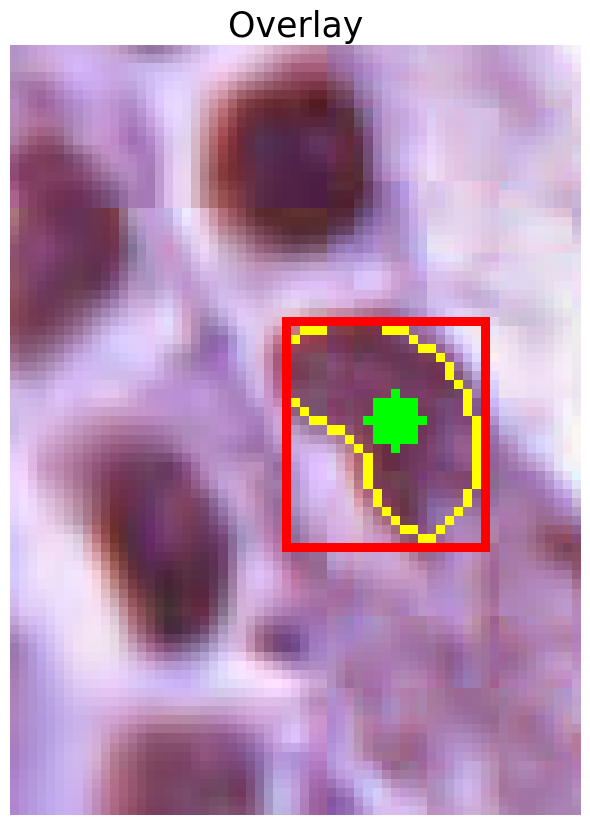

In [28]:
# plot the cropped overlay

pad = 30
crop1 = rand_bbox[0][0]-pad
if crop1 < 0: 
    crop1 = 0
crop2 = rand_bbox[1][0]+pad
if crop2 > overlay.shape[0]: 
    crop2 = overlay.shape[0]
crop3 = rand_bbox[0][1]-pad
if crop3 < 0: 
    crop3 = 0
crop4 = rand_bbox[1][1]+pad
if crop4 > overlay.shape[1]: 
    crop4 = overlay.shape[1]
crop_overlay = overlay[crop1:crop2,crop3:crop4,:]
plt.figure(figsize=(10,10))

plt.imshow(crop_overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()